In [107]:
from utils import *
import pickle
import pandas as pd
import os
import matplotlib

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RectBivariateSpline
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

## Testing

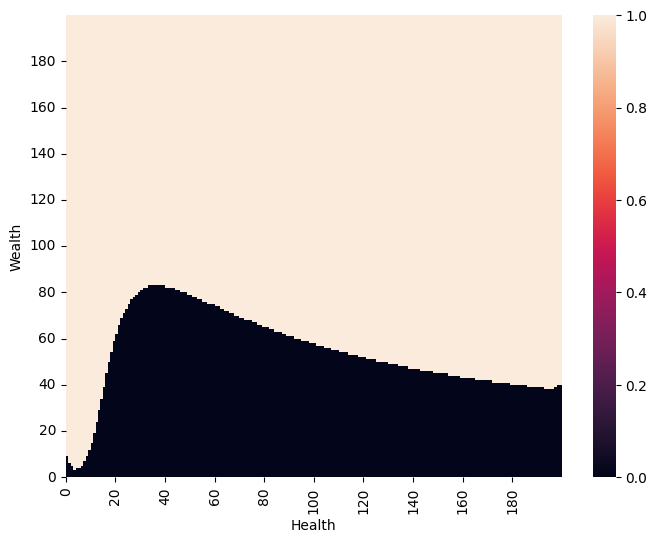

In [2]:
policy, params, _ = value_iteration(
    N=200,
    alpha=0.5567,
    gamma=0.6,
    theta=0.88,
    omega=2.25,
    eta=0.88,
    beta=0.95,
    P_H_increase=0.9,
    invest_cost=1,
    health_delta=3,
    health_decrease_scale=0.67
)

plot_policy_boundary(policy, params)

In [5]:
num_steps = 3000
num_agents = 10000

util, wealth, health = simulate(
    params,
    policy,
    num_steps,
    num_agents
)

# plot_utility_trajectories(util)

## Steady State

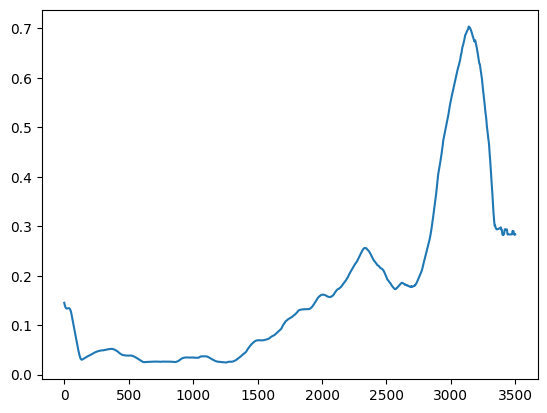

In [67]:
asdf = util[0,:]

cv = [np.std(asdf[i:i+500]) / np.mean(asdf[i:i+500]) for i in range(len(asdf)-500)]
plt.plot(cv)
plt.show()

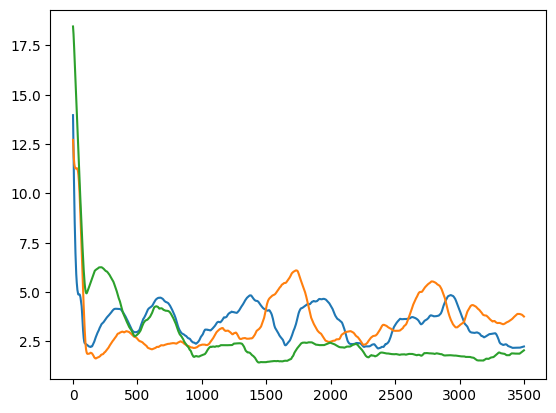

In [71]:
for i in range(6,9):
    
    asdf = util[i,:]

    cv = [np.std(asdf[i:i+500]) for i in range(len(asdf)-500)]
    plt.plot(cv)
plt.show()

# Results

In [2]:
filepath = "results/0.5568190175603988_1_3_0.67.pickle"
with open(filepath, "rb") as f:
    res = pickle.load(f)
wealth = res["wealth"]
health = res["health"]

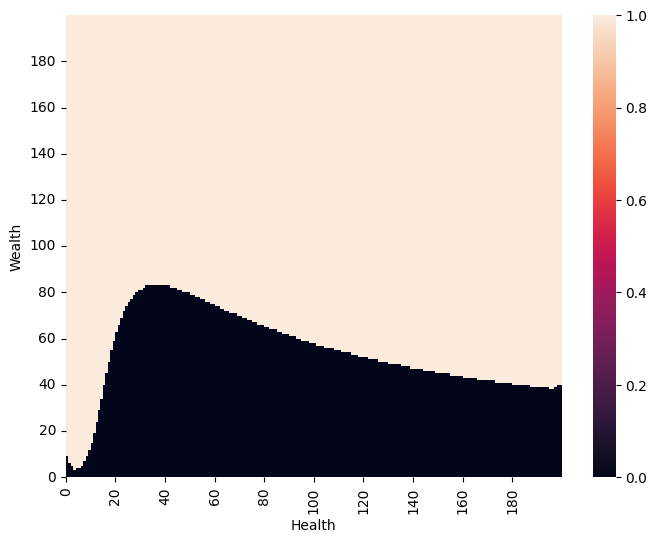

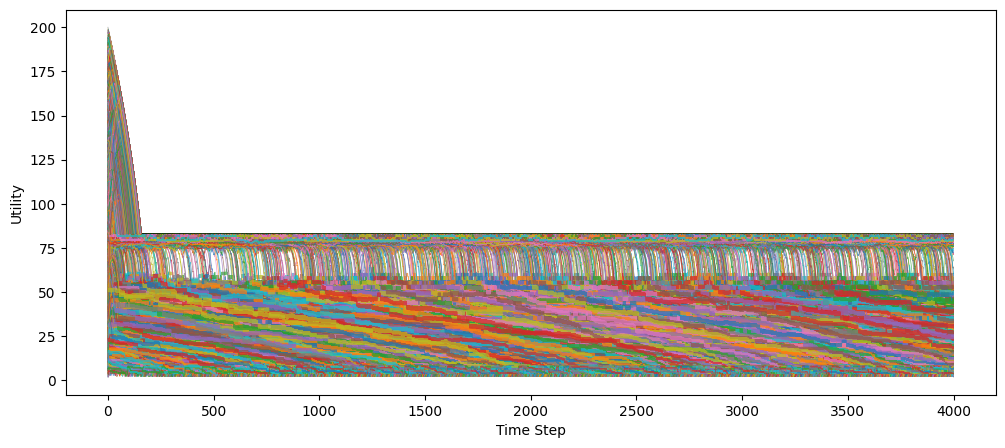

In [3]:
util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
plot_policy_boundary(res["policy"], res["params"])
plot_utility_trajectories(util)

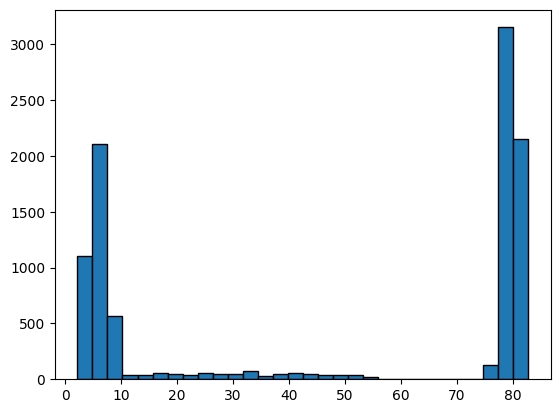

In [4]:
plt.hist(util[:,-1], bins=30, edgecolor='k')
plt.show()

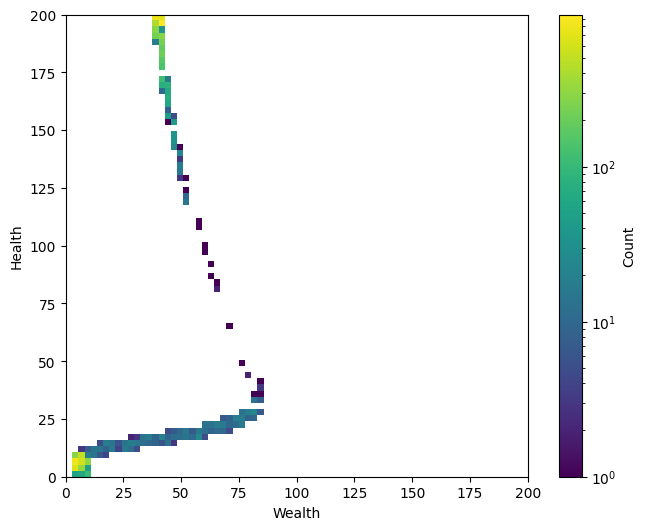

In [5]:
plot_wealth_health_distribution(wealth[:,-1], health[:,-1], 200)

## Mean First Passage Time (MFPT)

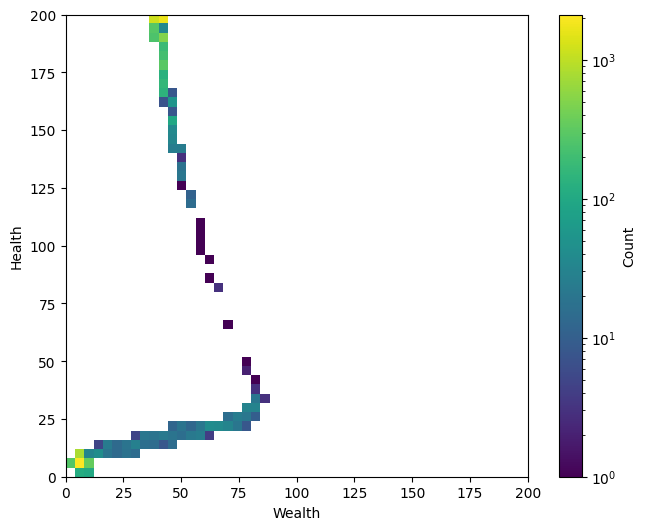

In [41]:
hist, xedges, yedges = np.histogram2d(wealth[:,-1], health[:,-1], bins=50, range=[(0,200), (0,200)])
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], norm="log")
plt.colorbar(label='Count')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.show()

In [42]:
# compute density and potential
density = hist / np.sum(hist)
with np.errstate(divide='ignore'):
    potential = -np.log(density)
    potential[np.isinf(potential)] = np.nan

# interpolation function
max_finite_value = np.nanmax(potential)
potential[np.isnan(potential)] = max_finite_value + 1
smoothed_potential = gaussian_filter(potential, sigma=1)

interp_func = RectBivariateSpline(np.linspace(0,199,len(xedges)-1), np.linspace(0,199,len(xedges)-1), smoothed_potential)
INTERPOLATION = np.zeros((200,200))
for i,x in enumerate(np.linspace(0, 199, 200)):
    for j,y in enumerate(np.linspace(0, 199, 200)):
        potential_at_point = interp_func(x, y)[0, 0]
        INTERPOLATION[i][j] = potential_at_point

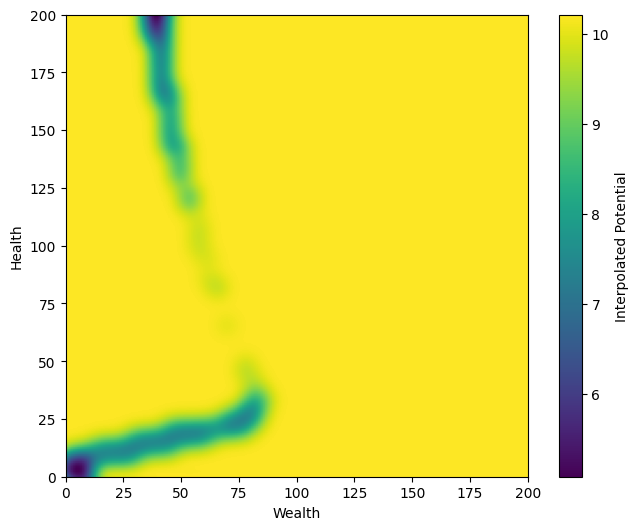

In [43]:
plt.figure(figsize=(8, 6))
plt.imshow(INTERPOLATION.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Interpolated Potential')
plt.xlabel('Wealth')
plt.ylabel('Health')
plt.show()

In [273]:
def compute_MFPT(n_steps, n_simulations, start_pos, target_pos, step_size, interpolate):
    rand_nums = np.random.uniform(0, 1, size=(n_steps, n_simulations))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps, n_simulations))

    target_x = np.full(n_simulations, target_pos[0])
    target_y = np.full(n_simulations, target_pos[1])

    X = np.zeros((n_simulations, n_steps+1))
    X[:,0] = start_pos[0]
    Y = np.zeros((n_simulations, n_steps+1))
    Y[:,0] = start_pos[1]

    still_moving = np.ones((n_simulations,))

    FPT = np.full_like(np.zeros(n_simulations,), n_steps)

    current_potential = interpolate(X[:,0], Y[:,0], grid=False)

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size
        new_potential = interpolate(X[:,step] + dx, Y[:,step] + dy, grid=False)

        # check whether to accept or reject moves
        accept = np.logical_or(new_potential < current_potential, rand_nums[step] < np.exp(current_potential - new_potential))
        current_potential = new_potential

        # update position
        X[:,step+1] = X[:,step] + accept * dx * still_moving
        Y[:,step+1] = Y[:,step] + accept * dy * still_moving

        reached_target = (X[:,step+1] - target_x)**2 + (Y[:,step+1] - target_y)**2 < step_size**2

        FPT = np.where(still_moving, np.where(reached_target, step, n_steps), FPT)

        still_moving = np.where(reached_target, 0, still_moving)
        
        if not np.any(still_moving):
            break

    return FPT.mean()

In [274]:
fpt = compute_MFPT(1000, 1000, (40,180), (40,190), 1, interp_func)
print(fpt)

597.303
613.591
601.754
613.038
589.893
600.625
593.605
599.387
605.022


KeyboardInterrupt: 

## Visualize average agent choices over time

In [15]:
adjusted_wealth = wealth - 1
adjusted_health = health - 1
indices = np.stack([adjusted_wealth, adjusted_health], axis=-1)
decisions = policy[indices[..., 0], indices[..., 1]]

In [127]:
rolling_means = np.array([
    np.convolve(decisions[a], np.ones(100)/100, mode='valid') 
    for a in range(decisions.shape[0])
])

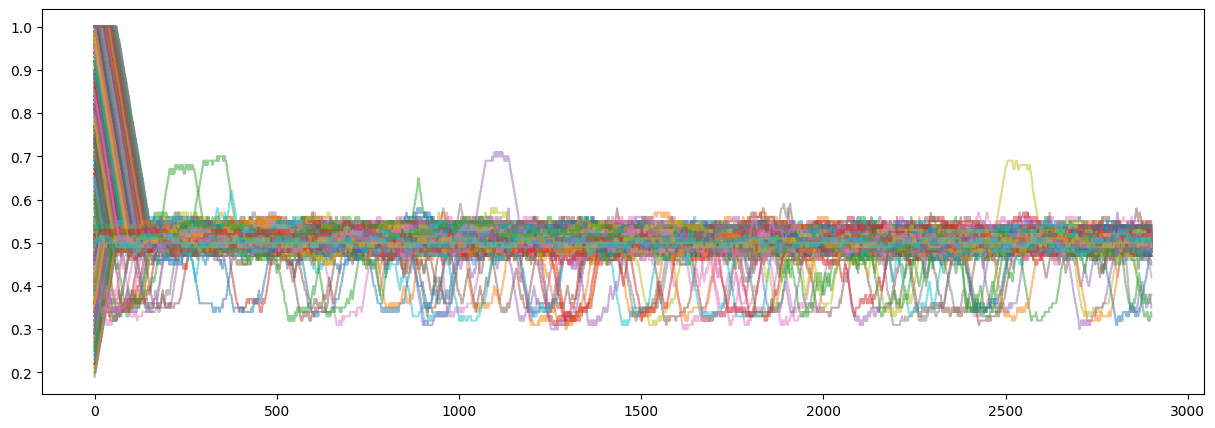

In [153]:
plt.figure(figsize=(15, 5))
plt.plot(rolling_means.T[:,:1000], alpha=0.5)
plt.show()